In [ ]:
import os
import sys
sys.path.append(f'{os.getcwd()}/../../')
sys.path.append(f'{os.getcwd()}/analytic')

In [2]:
import numpy             as np
import scipy             as sp
import magritte.setup    as setup
import magritte.core     as magritte
import magritte.mesher   as mesher
import healpy

dimension = 3
nrays     = 12*3**2
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
rho_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-8   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def rho (r):
    return rho_in * np.power(r_in/r, 2.0)

def abn (r):
    return X_mol * rho(r)


scale_max = 0.05 * r_out
scale_min = 0.05 * r_in
scale_cte = 0.05 * r_in
scale_fun = f"{scale_cte / r_in**2} * (x*x + y*y + z*z)"


meshName = 'vanZadelhoff_1a.vtk'

mesher.create_mesh_from_function(
    meshName       = meshName,
    boundary       = mesher.boundary_sphere_in_sphere(
                         radius_in  = r_in,
                         radius_out = r_out),
    scale_min      = scale_min,
    scale_max      = scale_max,
    scale_function = scale_fun )

Info    : Running 'gmsh vanZadelhoff_1a.geo -3 -saveall -o vanZadelhoff_1a.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Thu Nov  5 10:39:15 2020
Info    : Reading 'vanZadelhoff_1a.geo'...
Info    : Done reading 'vanZadelhoff_1a.geo'
Info    : Meshing 1D...
Info    : Meshing curve 101 (Circle)
Info    : Meshing curve 102 (Circle)
Info    : Meshing curve 103 (Circle)
Info    : Meshing curve 104 (Circle)
Info    : Meshing curve 105 (Circle)
Info    : Meshing curve 106 (Circle)
Info    : Meshing curve 107 (Circle)
Info    : Meshing curve 108 (Circle)
Info    : Meshing curve 109 (Circle)
Info    : Meshing curve 110 (Circle)
Info    : Meshing curve 111 (Circle)
Info    : Meshing curve 112 (Circle)
Info    : Meshing curve 201 (Circle)
Info    : Meshing curve 202 (Circle)
Info    : Meshing curve 203 (Circle)
Info    : Meshing curve 204 (Circle)
Info    : Meshing curve 205 (Circle)
Info    : Meshing curve 206 (Circle)
Info    : Meshing curve 207 (Circle)
Info    : Meshing curve

In [ ]:
mesh = mesher.Mesh(meshName)

npoints = len(mesh.points)
nbs     = [n for sublist in mesh.neighbors for n in sublist]
n_nbs   = [len(sublist) for sublist in mesh.neighbors]


modelFile = 'vanZadelhoff_1a_3D.hdf5'
lamdaFile = '../data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec  (1.0e-6)
model.parameters.set_model_name(modelFile)
model.parameters.set_dimension (dimension)
model.parameters.set_npoints   (npoints)
model.parameters.set_nrays     (nrays)
model.parameters.set_nspecs    (nspecs)
model.parameters.set_nlspecs   (nlspecs)
model.parameters.set_nquads    (nquads)


model.geometry.points.position.set(mesh.points)
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.geometry.points.multiscale.set_all_neighbors(n_nbs, nbs)
rs = np.linalg.norm(mesh.points, axis=1)

model.chemistry.species.abundance = [[     0.0, abn(r), rho(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

model.compute_level_populations       (False, 50)

0
6


In [4]:
import matplotlib.pyplot as plt

In [5]:
pops = np.array(model.lines.lineProducingSpecies[0].population).reshape((model.parameters.npoints(), 2))
abun = np.array(model.chemistry.species.abundance)[:,1]
r    = np.linalg.norm(np.array(model.geometry.points.position), axis=1)

In [6]:
(i,ra,rb,nh,tk,nm,vr,db,td,lp0,lp1) = np.loadtxt ('numeric/vanZadelhoff_1a.out', skiprows=14, unpack=True)

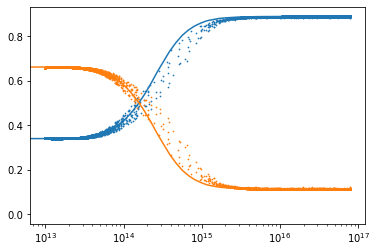

In [9]:
plt.scatter(r, pops[:,0]/abun, s=.5)
plt.scatter(r, pops[:,1]/abun, s=.5)

plt.plot(ra, lp0)
plt.plot(ra, lp1)


plt.xscale('log')
# plt.yscale('log')